# Description

This notebook runs some pre-analyses using spectral clustering to explore the best set of parameters to cluster `umap` data version.

# Environment variables

In [1]:
from IPython.display import display

import conf

N_JOBS = conf.GENERAL["N_JOBS"]
display(N_JOBS)

3

In [2]:
%env MKL_NUM_THREADS=$N_JOBS
%env OPEN_BLAS_NUM_THREADS=$N_JOBS
%env NUMEXPR_NUM_THREADS=$N_JOBS
%env OMP_NUM_THREADS=$N_JOBS

env: MKL_NUM_THREADS=3
env: OPEN_BLAS_NUM_THREADS=3
env: NUMEXPR_NUM_THREADS=3
env: OMP_NUM_THREADS=3


# Modules loading

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns

from utils import generate_result_set_name

# Settings

In [5]:
INITIAL_RANDOM_STATE = 50000

# UMAP

In [6]:
INPUT_SUBSET = "umap"

In [7]:
INPUT_STEM = "z_score_std-projection-smultixcan-efo_partial-mashr-zscores"

In [8]:
DR_OPTIONS = {
    "n_components": 50,
    "metric": "euclidean",
    "n_neighbors": 15,
    "random_state": 0,
}

In [9]:
input_filepath = Path(
    conf.RESULTS["DATA_TRANSFORMATIONS_DIR"],
    INPUT_SUBSET,
    generate_result_set_name(
        DR_OPTIONS, prefix=f"{INPUT_SUBSET}-{INPUT_STEM}-", suffix=".pkl"
    ),
).resolve()
display(input_filepath)

assert input_filepath.exists(), "Input file does not exist"

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base3/results/data_transformations/umap/umap-z_score_std-projection-smultixcan-efo_partial-mashr-zscores-metric_euclidean-n_components_50-n_neighbors_15-random_state_0.pkl')

'umap-z_score_std-projection-smultixcan-efo_partial-mashr-zscores-metric_euclidean-n_components_50-n_neighbors_15-random_state_0'

In [10]:
data = pd.read_pickle(input_filepath)

In [11]:
data.shape

(3749, 50)

In [12]:
data.head()

,UMAP1,UMAP2,UMAP3,UMAP4,UMAP5,UMAP6,UMAP7,UMAP8,UMAP9,UMAP10,...,UMAP41,UMAP42,UMAP43,UMAP44,UMAP45,UMAP46,UMAP47,UMAP48,UMAP49,UMAP50
100001_raw-Food_weight,11.531590,10.773390,10.551500,5.689103,12.646474,8.795625,2.365859,-3.382425,1.458605,14.236823,...,2.214731,9.304909,3.359118,5.211676,1.265622,2.058685,1.291174,1.565621,7.317275,9.037535
100002_raw-Energy,11.554761,10.753816,10.548004,5.710800,12.674987,8.787647,2.379787,-3.339913,1.442655,14.196218,...,2.237087,9.270699,3.383440,5.185328,1.257113,2.057439,1.290686,1.557209,7.297037,9.009866
100003_raw-Protein,11.519615,10.786408,10.540249,5.687959,12.628188,8.789925,2.368370,-3.390937,1.464806,14.233623,...,2.216162,9.314158,3.350708,5.226166,1.267382,2.051692,1.305047,1.558942,7.307035,9.042575
100004_raw-Fat,11.515584,10.756584,10.570711,5.697041,12.661936,8.787330,2.396913,-3.351611,1.435632,14.221588,...,2.214707,9.273252,3.383349,5.220068,1.270067,2.065669,1.281447,1.578588,7.332527,9.005523
100005_raw-Carbohydrate,11.528723,10.762026,10.566773,5.698555,12.671127,8.791903,2.394764,-3.354370,1.442259,14.226301,...,2.216362,9.275563,3.383139,5.216354,1.269187,2.063429,1.280020,1.577227,7.335059,9.009464


# Clustering

In [13]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score

## `gamma` parameter

### Using default value (`gamma=1.0`)

In [14]:
with warnings.catch_warnings():
    warnings.filterwarnings("always")

    clus = SpectralClustering(
        eigen_solver="arpack",
        #         eigen_tol=1e-3,
        n_clusters=2,
        n_init=1,
        affinity="rbf",
        gamma=1.00,
        random_state=INITIAL_RANDOM_STATE,
    )

    part = clus.fit_predict(data)

In [15]:
# show number of clusters and their size
pd.Series(part).value_counts()

0    3741
1       8
dtype: int64

In [16]:
# From sklearn website:
# The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters.
# Negative values generally indicate that a sample has been assigned to the wrong cluster,
# as a different cluster is more similar
silhouette_score(data, part)

0.8465178

In [17]:
# From sklearn website:
# The score is defined as ratio between the within-cluster dispersion and the between-cluster dispersion
calinski_harabasz_score(data, part)

374.93011416107225

For default values of `gamma` (`1.0`), the algorithm works fine with this data version.

### Using `gamma>1.0` (larger than default value)

In [18]:
with warnings.catch_warnings():
    warnings.filterwarnings("always")

    clus = SpectralClustering(
        eigen_solver="arpack",
        #         eigen_tol=1e-4,
        n_clusters=2,
        n_init=1,
        affinity="rbf",
        gamma=2.50,
        random_state=INITIAL_RANDOM_STATE,
    )

    part = clus.fit_predict(data)

In [19]:
# show number of clusters and their size
pd.Series(part).value_counts()

0    3743
1       6
dtype: int64

In [20]:
# From sklearn website:
# The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters.
# Negative values generally indicate that a sample has been assigned to the wrong cluster,
# as a different cluster is more similar
silhouette_score(data, part)

0.34538513

In [21]:
# From sklearn website:
# The score is defined as ratio between the within-cluster dispersion and the between-cluster dispersion
calinski_harabasz_score(data, part)

9.366943594833044

For `gamma` values largen than the default (`1.0`), quality measures go down.

### Using `gamma<1.0` (smaller than default value)

In [22]:
with warnings.catch_warnings():
    warnings.filterwarnings("always")

    clus = SpectralClustering(
        eigen_solver="arpack",
        #         eigen_tol=1e-3,
        n_clusters=2,
        n_init=1,
        affinity="rbf",
        gamma=0.01,
        random_state=INITIAL_RANDOM_STATE,
    )

    part = clus.fit_predict(data)

In [23]:
# show number of clusters and their size
pd.Series(part).value_counts()

0    3688
1      61
dtype: int64

In [24]:
# From sklearn website:
# The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters.
# Negative values generally indicate that a sample has been assigned to the wrong cluster,
# as a different cluster is more similar
silhouette_score(data, part)

0.8607793

In [25]:
# From sklearn website:
# The score is defined as ratio between the within-cluster dispersion and the between-cluster dispersion. Higher is better.
calinski_harabasz_score(data, part)

4641.627826464735

For `gamma` values around `0.01`, clustering quality measures improve. I will explore more around these values.

## Extended test

Here I run some test across several `k` and `gamma` values; then I check how results perform with different clustering quality measures.

In [26]:
CLUSTERING_OPTIONS = {}

CLUSTERING_OPTIONS["K_RANGE"] = [2, 4, 6, 8, 10, 20, 30, 40, 50, 60]
CLUSTERING_OPTIONS["N_REPS_PER_K"] = 5
CLUSTERING_OPTIONS["KMEANS_N_INIT"] = 10
CLUSTERING_OPTIONS["GAMMAS"] = [
    1.00,
    1e-02,
    #     1e-04,
    #     1e-05,
    1e-05,
    #     1e-06,
    #     1e-07,
    #     1e-08,
    #     1e-09,
    1e-10,
    #     1e-11,
    #     1e-12,
    #     1e-13,
    #     1e-14,
    1e-15,
    #     1e-17,
    1e-20,
    #     1e-30,
    #     1e-40,
    1e-50,
]
CLUSTERING_OPTIONS["AFFINITY"] = "rbf"

display(CLUSTERING_OPTIONS)

{'K_RANGE': [2, 4, 6, 8, 10, 20, 30, 40, 50, 60],
 'N_REPS_PER_K': 5,
 'KMEANS_N_INIT': 10,
 'GAMMAS': [1.0, 0.01, 1e-05, 1e-10, 1e-15, 1e-20, 1e-50],
 'AFFINITY': 'rbf'}

In [27]:
CLUSTERERS = {}

idx = 0
random_state = INITIAL_RANDOM_STATE

for k in CLUSTERING_OPTIONS["K_RANGE"]:
    for gamma_value in CLUSTERING_OPTIONS["GAMMAS"]:
        for i in range(CLUSTERING_OPTIONS["N_REPS_PER_K"]):
            clus = SpectralClustering(
                eigen_solver="arpack",
                n_clusters=k,
                n_init=CLUSTERING_OPTIONS["KMEANS_N_INIT"],
                affinity=CLUSTERING_OPTIONS["AFFINITY"],
                gamma=gamma_value,
                random_state=random_state,
            )

            method_name = type(clus).__name__
            CLUSTERERS[f"{method_name} #{idx}"] = clus

            random_state = random_state + 1
            idx = idx + 1

In [28]:
display(len(CLUSTERERS))

350

In [29]:
_iter = iter(CLUSTERERS.items())
display(next(_iter))
display(next(_iter))

('SpectralClustering #0',
 SpectralClustering(eigen_solver='arpack', n_clusters=2, random_state=50000))

('SpectralClustering #1',
 SpectralClustering(eigen_solver='arpack', n_clusters=2, random_state=50001))

In [30]:
clustering_method_name = method_name
display(clustering_method_name)

'SpectralClustering'

## Generate ensemble

In [31]:
import tempfile
from clustering.ensemble import generate_ensemble

In [32]:
# generate a temporary folder where to store the ensemble and avoid computing it again
ensemble_folder = Path(
    tempfile.gettempdir(),
    f"pre_cluster_analysis",
    clustering_method_name,
).resolve()
ensemble_folder.mkdir(parents=True, exist_ok=True)

In [33]:
ensemble_file = Path(
    ensemble_folder,
    generate_result_set_name(
        CLUSTERING_OPTIONS, prefix=f"ensemble-{INPUT_SUBSET}-", suffix=".pkl"
    ),
)
display(ensemble_file)

PosixPath('/tmp/pre_cluster_analysis/SpectralClustering/ensemble-umap-AFFINITY_rbf-GAMMAS_10_001_1e_05_1e_10_1e_15_1e_20_1e_50-KMEANS_N_INIT_10-K_RANGE_2_4_6_8_10_20_30_40_50_60-N_REPS_PER_K_5.pkl')

In [34]:
if ensemble_file.exists():
    display(f"Ensemble file exists")
    ensemble = pd.read_pickle(ensemble_file)
else:
    ensemble = generate_ensemble(
        data,
        CLUSTERERS,
        attributes=["n_clusters", "gamma"],
    )

    ensemble.to_pickle(ensemble_file)

100%|██████████| 350/350 [14:59<00:00,  2.57s/it]


In [35]:
ensemble.shape

(350, 4)

In [36]:
ensemble.head()

,clusterer_params,partition,n_clusters,gamma
clusterer_id,,,,
SpectralClustering #0,"{'affinity': 'rbf', 'assign_labels': 'kmeans',...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,1.0
SpectralClustering #1,"{'affinity': 'rbf', 'assign_labels': 'kmeans',...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,1.0
SpectralClustering #2,"{'affinity': 'rbf', 'assign_labels': 'kmeans',...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,1.0
SpectralClustering #3,"{'affinity': 'rbf', 'assign_labels': 'kmeans',...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,1.0
SpectralClustering #4,"{'affinity': 'rbf', 'assign_labels': 'kmeans',...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,1.0


In [37]:
ensemble["gamma"] = ensemble["gamma"].apply(lambda x: f"{x:.1e}")

In [38]:
ensemble["n_clusters"].value_counts()

60    35
50    35
40    35
30    35
20    35
10    35
8     35
6     35
4     35
2     35
Name: n_clusters, dtype: int64

In [39]:
_tmp = ensemble["n_clusters"].value_counts().unique()
assert _tmp.shape[0] == 1
assert _tmp[0] == int(
    CLUSTERING_OPTIONS["N_REPS_PER_K"] * len(CLUSTERING_OPTIONS["GAMMAS"])
)

In [40]:
ensemble_stats = ensemble["n_clusters"].describe()
display(ensemble_stats)

count    350.000000
mean      23.000000
std       19.852609
min        2.000000
25%        6.000000
50%       15.000000
75%       40.000000
max       60.000000
Name: n_clusters, dtype: float64

### Testing

In [41]:
assert ensemble_stats["min"] > 1

In [42]:
assert not ensemble["n_clusters"].isna().any()

In [43]:
assert ensemble.shape[0] == len(CLUSTERERS)

In [44]:
# all partitions have the right size
assert np.all(
    [part["partition"].shape[0] == data.shape[0] for idx, part in ensemble.iterrows()]
)

In [45]:
# no partition has negative clusters (noisy points)
assert not np.any([(part["partition"] < 0).any() for idx, part in ensemble.iterrows()])

In [46]:
# check that the number of clusters in the partitions are the expected ones
_real_k_values = ensemble["partition"].apply(lambda x: np.unique(x).shape[0])
display(_real_k_values)
assert np.all(ensemble["n_clusters"].values == _real_k_values.values)

clusterer_id
SpectralClustering #0       2
SpectralClustering #1       2
SpectralClustering #2       2
SpectralClustering #3       2
SpectralClustering #4       2
                           ..
SpectralClustering #345    60
SpectralClustering #346    60
SpectralClustering #347    60
SpectralClustering #348    60
SpectralClustering #349    60
Name: partition, Length: 350, dtype: int64

### Add clustering quality measures

In [47]:
ensemble = ensemble.assign(
    ch_score=ensemble["partition"].apply(lambda x: calinski_harabasz_score(data, x))
)

In [48]:
ensemble.shape

(350, 5)

In [49]:
ensemble.head()

,clusterer_params,partition,n_clusters,gamma,ch_score
clusterer_id,,,,,
SpectralClustering #0,"{'affinity': 'rbf', 'assign_labels': 'kmeans',...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,1.0e+00,374.930114
SpectralClustering #1,"{'affinity': 'rbf', 'assign_labels': 'kmeans',...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,1.0e+00,719.462482
SpectralClustering #2,"{'affinity': 'rbf', 'assign_labels': 'kmeans',...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,1.0e+00,374.930114
SpectralClustering #3,"{'affinity': 'rbf', 'assign_labels': 'kmeans',...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,1.0e+00,413.556449
SpectralClustering #4,"{'affinity': 'rbf', 'assign_labels': 'kmeans',...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,1.0e+00,374.930114


# Cluster quality

In [50]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    _df = ensemble.groupby(["n_clusters", "gamma"]).mean()
    display(_df)

ch_score
n_clusters gamma               
2          1.0e+00   451.561855
           1.0e-02  4641.627826
           1.0e-05  4641.627826
           1.0e-10  4641.627826
           1.0e-15  3885.895448
           1.0e-20     2.096855
           1.0e-50     1.859119
4          1.0e+00  1692.619885
           1.0e-02  2227.943399
           1.0e-05  2778.678882
           1.0e-10  2778.678882
           1.0e-15  1272.631139
           1.0e-20     0.716896
           1.0e-50     1.356397
6          1.0e+00  1752.754447
           1.0e-02  2011.776339
           1.0e-05  1922.578744
           1.0e-10  1922.733430
           1.0e-15   628.175106
           1.0e-20     1.203606
           1.0e-50     1.733398
8          1.0e+00   659.090291
           1.0e-02  1543.156782
           1.0e-05  1530.975222
           1.0e-10  1531.529012
           1.0e-15   443.771670
           1.0e-20     1.627796
           1.0e-50     1.595965
10         1.0e+00   547.284963
           1.0e-02  1292.913866
           1.0e-05  1297.368697
           1.0e-10  1297.871898
           1.0e-15   374.314738
           1.0e-20     0.882354
           1.0e-50     1.380046
20         1.0e+00   728.463140
           1.0e-02   807.562423
           1.0e-05   768.778176
           1.0e-10   777.722528
           1.0e-15   147.423480
           1.0e-20     1.201431
           1.0e-50     1.609471
30         1.0e+00   523.341831
           1.0e-02   578.244071
           1.0e-05   560.700000
           1.0e-10   562.537906
           1.0e-15   101.280102
           1.0e-20     0.928312
           1.0e-50     0.917599
40         1.0e+00   441.616721
           1.0e-02   485.230015
           1.0e-05   456.805211
           1.0e-10   452.919083
           1.0e-15    73.308147
           1.0e-20     1.508415
           1.0e-50     1.026980
50         1.0e+00   383.221918
           1.0e-02   420.712090
           1.0e-05   369.503630
           1.0e-10   358.032117
           1.0e-15    61.070809
           1.0e-20     0.889372
           1.0e-50     1.306022
60         1.0e+00   344.417659
           1.0e-02   391.942961
           1.0e-05   301.813494
           1.0e-10   293.537717
           1.0e-15    25.947582
           1.0e-20     1.590548
           1.0e-50     1.834428

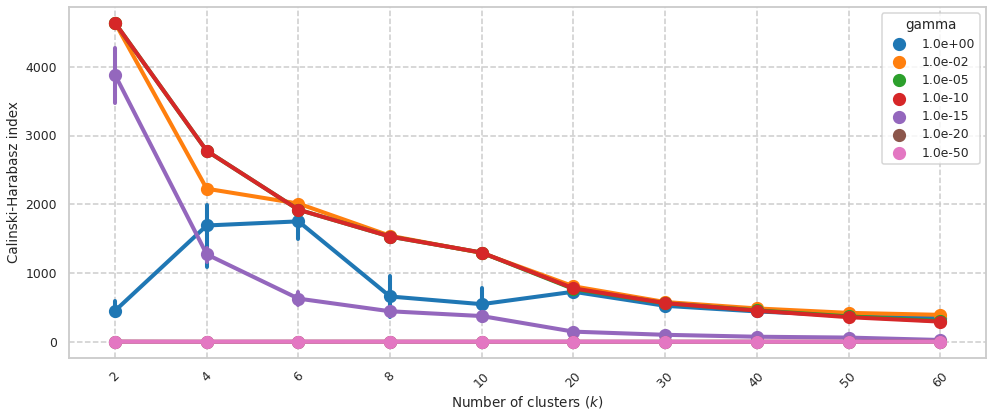

In [51]:
# with sns.axes_style('whitegrid', {'grid.linestyle': '--'}):
with sns.plotting_context("talk", font_scale=0.75), sns.axes_style(
    "whitegrid", {"grid.linestyle": "--"}
):
    fig = plt.figure(figsize=(14, 6))
    ax = sns.pointplot(data=ensemble, x="n_clusters", y="ch_score", hue="gamma")
    ax.set_ylabel("Calinski-Harabasz index")
    ax.set_xlabel("Number of clusters ($k$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    #     ax.set_ylim(0.0, 1.0)
    #     ax.set_xlim(CLUSTERING_OPTIONS['K_MIN'], CLUSTERING_OPTIONS['K_MAX'])
    plt.grid(True)
    plt.tight_layout()

# Stability

## Group ensemble by n_clusters

In [52]:
parts = ensemble.groupby(["gamma", "n_clusters"]).apply(
    lambda x: np.concatenate(x["partition"].apply(lambda x: x.reshape(1, -1)), axis=0)
)

In [53]:
parts.shape

(70,)

In [54]:
parts.head()

gamma    n_clusters
1.0e+00  2             [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
         4             [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
         6             [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
         8             [[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0,...
         10            [[7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0,...
dtype: object

In [55]:
parts.iloc[0].shape

(5, 3749)

In [56]:
assert np.all(
    [
        parts.loc[k].shape == (int(CLUSTERING_OPTIONS["N_REPS_PER_K"]), data.shape[0])
        for k in parts.index
    ]
)

## Compute stability

In [57]:
from sklearn.metrics import adjusted_rand_score as ari
from scipy.spatial.distance import squareform, pdist

In [58]:
parts_ari = pd.Series(
    {k: pdist(parts.loc[k], metric=ari) for k in parts.index}, name="n_clusters"
)

In [59]:
parts_ari_stability = parts_ari.apply(lambda x: x.mean())
display(parts_ari_stability.sort_values(ascending=False).head(15))

1.0e-05  2     1.000000
1.0e-10  4     1.000000
         2     1.000000
1.0e-02  2     1.000000
1.0e-05  4     1.000000
1.0e-02  4     0.997812
1.0e-05  10    0.990555
1.0e-10  8     0.982375
1.0e-05  6     0.982140
1.0e-10  6     0.978015
1.0e-02  8     0.975395
         6     0.953305
         10    0.902924
1.0e-15  2     0.899899
1.0e-05  8     0.893820
Name: n_clusters, dtype: float64

In [60]:
parts_ari_df = pd.DataFrame.from_records(parts_ari.tolist()).set_index(
    parts_ari.index.copy()
)
parts_ari_df.index.rename(["gamma", "n_clusters"], inplace=True)

In [61]:
parts_ari_df.shape

(70, 10)

In [62]:
_n_total_parts = int(
    CLUSTERING_OPTIONS["N_REPS_PER_K"]
)  # * len(CLUSTERING_OPTIONS["GAMMAS"]))

assert int(_n_total_parts * (_n_total_parts - 1) / 2) == parts_ari_df.shape[1]

In [63]:
parts_ari_df.head()

0         1         2         3         4  \
gamma   n_clusters                                                     
1.0e+00 2           0.568279  1.000000 -0.002555  1.000000  0.568279   
        4           0.084488  0.084488  0.084488  0.084488  1.000000   
        6           1.000000  1.000000  1.000000  0.276607  1.000000   
        8           0.363849  1.000000  0.458020  0.363849  0.363849   
        10          0.456522  0.456522  1.000000  0.456522  1.000000   

                           5         6         7         8         9  
gamma   n_clusters                                                    
1.0e+00 2           0.747383  0.568279 -0.002555  1.000000 -0.002555  
        4           1.000000  1.000000  1.000000  1.000000  1.000000  
        6           1.000000  0.276607  1.000000  0.276607  0.276607  
        8           0.912533  1.000000  0.458020  0.363849  0.912533  
        10          0.456522  1.000000  0.456522  1.000000  0.456522

## Stability plot

In [64]:
parts_ari_df_plot = (
    parts_ari_df.stack().reset_index().rename(columns={"level_2": "idx", 0: "ari"})
)

In [65]:
parts_ari_df_plot.dtypes

gamma          object
n_clusters      int64
idx             int64
ari           float64
dtype: object

In [66]:
parts_ari_df_plot.head()

,gamma,n_clusters,idx,ari
0,1.0e+00,2,0,0.568279
1,1.0e+00,2,1,1.000000
2,1.0e+00,2,2,-0.002555
3,1.0e+00,2,3,1.000000
4,1.0e+00,2,4,0.568279


In [67]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    _df = parts_ari_df_plot.groupby(["n_clusters", "gamma"]).mean()
    display(_df)

idx       ari
n_clusters gamma                 
2          1.0e+00  4.5  0.544456
           1.0e-02  4.5  1.000000
           1.0e-05  4.5  1.000000
           1.0e-10  4.5  1.000000
           1.0e-15  4.5  0.899899
           1.0e-20  4.5  0.006633
           1.0e-50  4.5 -0.000556
4          1.0e+00  4.5  0.633795
           1.0e-02  4.5  0.997812
           1.0e-05  4.5  1.000000
           1.0e-10  4.5  1.000000
           1.0e-15  4.5  0.225563
           1.0e-20  4.5 -0.002691
           1.0e-50  4.5  0.002186
6          1.0e+00  4.5  0.710643
           1.0e-02  4.5  0.953305
           1.0e-05  4.5  0.982140
           1.0e-10  4.5  0.978015
           1.0e-15  4.5  0.079089
           1.0e-20  4.5  0.003209
           1.0e-50  4.5  0.000573
8          1.0e+00  4.5  0.619650
           1.0e-02  4.5  0.975395
           1.0e-05  4.5  0.893820
           1.0e-10  4.5  0.982375
           1.0e-15  4.5  0.083948
           1.0e-20  4.5 -0.000365
           1.0e-50  4.5  0.005254
10         1.0e+00  4.5  0.673913
           1.0e-02  4.5  0.902924
           1.0e-05  4.5  0.990555
           1.0e-10  4.5  0.876884
           1.0e-15  4.5  0.044408
           1.0e-20  4.5  0.000288
           1.0e-50  4.5 -0.003058
20         1.0e+00  4.5  0.680336
           1.0e-02  4.5  0.449127
           1.0e-05  4.5  0.469361
           1.0e-10  4.5  0.537759
           1.0e-15  4.5  0.030521
           1.0e-20  4.5 -0.000262
           1.0e-50  4.5  0.001159
30         1.0e+00  4.5  0.543545
           1.0e-02  4.5  0.414316
           1.0e-05  4.5  0.414023
           1.0e-10  4.5  0.447108
           1.0e-15  4.5  0.018577
           1.0e-20  4.5 -0.002560
           1.0e-50  4.5  0.000134
40         1.0e+00  4.5  0.317496
           1.0e-02  4.5  0.352824
           1.0e-05  4.5  0.418918
           1.0e-10  4.5  0.397159
           1.0e-15  4.5  0.020857
           1.0e-20  4.5 -0.004211
           1.0e-50  4.5  0.003881
50         1.0e+00  4.5  0.270891
           1.0e-02  4.5  0.369428
           1.0e-05  4.5  0.434168
           1.0e-10  4.5  0.412429
           1.0e-15  4.5  0.029084
           1.0e-20  4.5  0.005230
           1.0e-50  4.5  0.003611
60         1.0e+00  4.5  0.324365
           1.0e-02  4.5  0.438559
           1.0e-05  4.5  0.423509
           1.0e-10  4.5  0.405138
           1.0e-15  4.5  0.021986
           1.0e-20  4.5 -0.000219
           1.0e-50  4.5 -0.002835

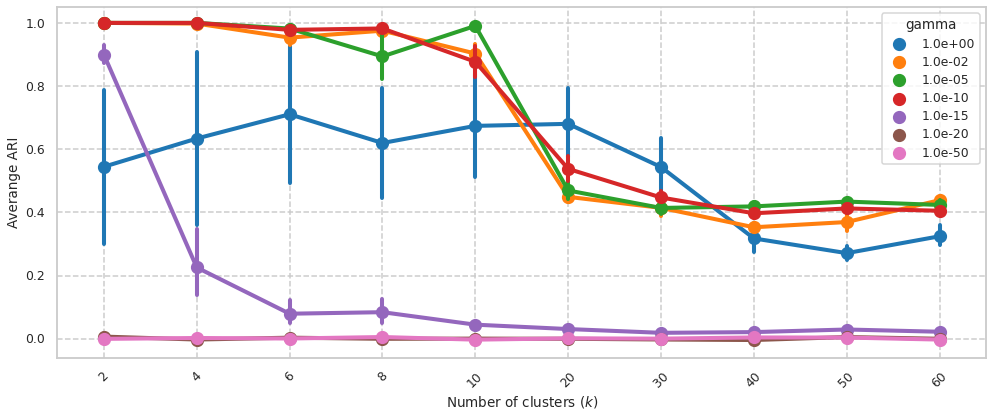

In [68]:
with sns.plotting_context("talk", font_scale=0.75), sns.axes_style(
    "whitegrid", {"grid.linestyle": "--"}
):
    fig = plt.figure(figsize=(14, 6))
    ax = sns.pointplot(data=parts_ari_df_plot, x="n_clusters", y="ari", hue="gamma")
    ax.set_ylabel("Averange ARI")
    ax.set_xlabel("Number of clusters ($k$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.grid(True)
    plt.tight_layout()

**CONCLUSION:** We choose `1e-10` as the `gamma` parameter for this data version.